# CRAFTY

All'interno della cartella si trovano i seguenti file:

- crafty_code.py file che contiene il codice Python in formato .py (nel caso ci fossero problemi di leggibilià o di esecuzione del codice)
- crafty.ipynb: file che contiene il codice Python 
- README.md: file che contiene la relazione del progetto (è la stessa relazione contenuta nel Jupyter ma in lingua inglese e unificata)
- wallets_WE.json: file che contiene i 10 cluster più grandi, deanonimizzati attraverso Wallet Explorer
- wallets_BIC.json: file che contiene i 10 cluster più grandi, deanonimizzati attraverso Bitcoin Info Charts

ATTENZIONE: se si vuole eseguire il codice senza modificare i file JSON, ci sono due possibilità:

- Si può eseguire il codice in fino alla sezione *Clustering* e fermarsi prima di eseguire la parte di *Web Scraping*
- Si può commentare, in entrambi i metodi, la parte di codice che aggiorna i file JSON (in questo modo però si dovranno aspettare i tempi di esecuzione molto alti del codice 6/7 minuti per metodo di scraping)

### Some utility imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import requests
import json
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

### Read all csv file

Read transactions.csv and convert all timestamp to readable dates

Read inputs.csv and outputs.csv

Read mapping.csv and set its index to the address ID so it will be easier to access

In [2]:
# --- Read transactions file ---
transactions = pd.read_csv('./Dataset/transactions.csv', names = ['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'])
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit = 's') # Convert UNIX timestamp to readable date

# --- Read inputs file ---
inputs = pd.read_csv('./Dataset/inputs.csv', names = ['txId', 'prevTxId', 'prevTxPos'])

# --- Read outputs file ---
outputs = pd.read_csv('./Dataset/outputs.csv', names = ['txId', 'position', 'addressId', 'amount', 'scriptType'])

# --- Read mapping file ---
mapping = pd.read_csv('./Dataset/mapping.csv', names = ['hash', 'addressId'])
mapping.set_index('addressId', inplace = True)

## Analysis

### 1) Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

Per svolgere questa analisi basta raggruppare le transazioni sul campo 'blockId' e applicare la funzione `size()`, successivamente eseguo un plot in cui ho aggiunto un secondo subplot che mostra la distribuzione cumulativa delle transazioni in base all'ID del blocco. Ho calcolato la somma cumulativa delle transazioni utilizzando la funzione `np.cumsum()` e l'ho rappresentata nel secondo subplot condividendo l'asse x tra i due subplot (`sharex = True`). Ho aggiunto delle griglie ai due subplot e una legenda per ciascun subplot per indicare cosa rappresentano le linee tracciate.

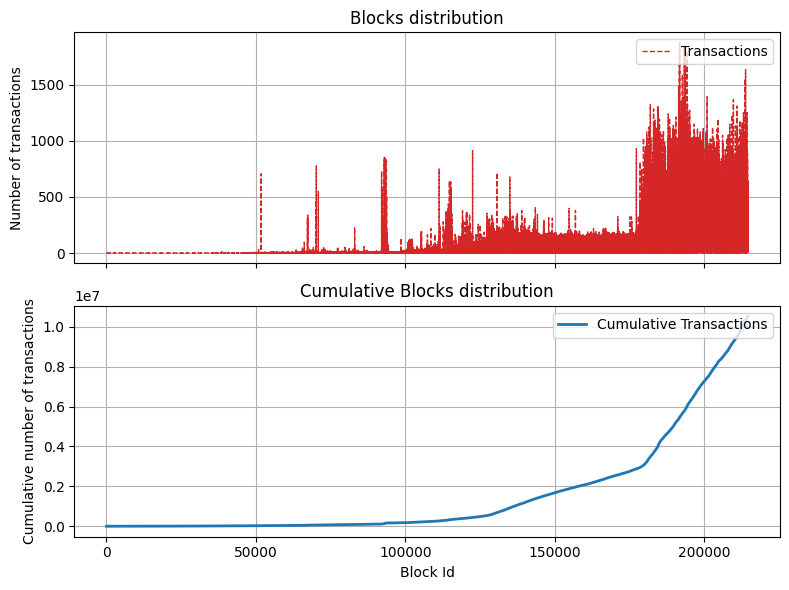

In [3]:
# --- (1) Number of transactions per block ---

# Calculation ...
tx_distribution = transactions.groupby('blockId').size() # Number of transactions per block
cumulative_tx = np.cumsum(tx_distribution) # Cumulative sum of transactions

# Plotting ...

# Create a figure and axes for subplots
fig, ax = plt.subplots(2, 1, figsize = (8, 6), sharex = True)

# Plotting the transaction distribution
ax[0].plot(tx_distribution, color = 'tab:red', linestyle = 'dashed', linewidth = 1)
ax[0].set_title('Blocks distribution')
ax[0].set_ylabel('Number of transactions')

# Plotting the cumulative transaction distribution
ax[1].plot(cumulative_tx, color = 'tab:blue', linewidth = 2)
ax[1].set_title('Cumulative Blocks distribution')
ax[1].set_xlabel('Block Id')
ax[1].set_ylabel('Cumulative number of transactions')

# Add gridlines
ax[0].grid(True)
ax[1].grid(True)

# Add a legend
ax[0].legend(['Transactions'], loc = 'upper right')
ax[1].legend(['Cumulative Transactions'], loc = 'upper right')

# Display the plot
plt.tight_layout() # Adjust the padding between and around subplots
plt.show()

### 2) Evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi. In questo caso produrre un grafico che riporti il numero di transazioni medie per ogni periodo considerato

Parto creando un range di date con frequenza di un mese (quindi ogni coppia sarà composta da due mesi) a partire dalla data **2009-01-03** alla data **2012-12-31** usando la funzione della librearia Pandas `data_range()`. Per ogni coppia di date seleziono le transazioni comprese tra esse e le raggruppo per 'blockId' calcolandone la distribuzione media. Poi controllo quale sia il primo mese di ogni coppia per raggruppare in un grouped bar plot le coppie di mesi distribuite nel corso dei 4 anni. 

Si può notare che in questo caso come il numero di transazioni sia aumentato nel corso degli anni, specialmente a partire dal 2011.

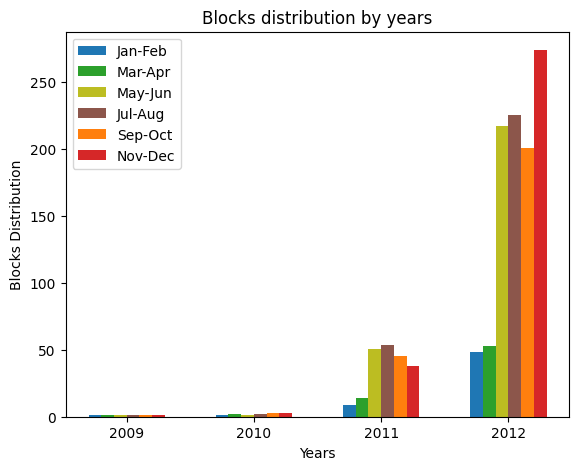

In [4]:
# --- (2) Number of transactions per block on two months ---

# Calculation ...
two_months_list = pd.date_range(start = '2009-01-03', end = '2012-12-31', freq = '1M') # List of dates with 2 months interval

# Initialize lists
months_list = list()
jan_feb = list()
mar_apr = list()
may_jun = list()
jul_aug = list()
sep_oct = list()
nov_dec = list()

# For each date in the list, get the transactions between each pair of months
for i in range(0, len(two_months_list) - 1, 2):
  two_months = transactions[transactions['timestamp'].between(two_months_list[i], two_months_list[i + 1])] # Get transactions between two months

  monthly_tx_distribution = two_months.groupby('blockId').size() # Number of transactions per block
  monthly_distribution_mean = monthly_tx_distribution.mean() # Mean of transactions per block

  # Append the mean of transactions per block to the corresponding month
  if (two_months_list[i].month_name() == 'January'):
    jan_feb.append(monthly_distribution_mean)
  if (two_months_list[i].month_name() == 'March'):
    mar_apr.append(monthly_distribution_mean)
  if (two_months_list[i].month_name() == 'May'):
    may_jun.append(monthly_distribution_mean)
  if (two_months_list[i].month_name() == 'July'):
    jul_aug.append(monthly_distribution_mean)
  if (two_months_list[i].month_name() == 'September'):
    sep_oct.append(monthly_distribution_mean)
  if (two_months_list[i].month_name() == 'November'):
    nov_dec.append(monthly_distribution_mean)

# Plotting ...
x = np.array([1, 2, 3, 4])
width = 0.1

fig, ax = plt.subplots(1, 1, figsize = (6.5, 5))
ax.set_title('Blocks distribution by years')
bar1 = ax.bar(x - 2 * width, jan_feb, width, color = 'tab:blue')
bar2 = ax.bar(x - width, mar_apr, width, color = 'tab:green')
bar3 = ax.bar(x, may_jun, width, color = 'tab:olive')
bar4 = ax.bar(x + width, jul_aug, width, color = 'tab:brown')
bar5 = ax.bar(x + 2 * width, sep_oct, width, color = 'tab:orange')
bar6 = ax.bar(x + 3 * width, nov_dec, width, color = 'tab:red')
ax.set_xticks(x + width/2, [2009, 2010, 2011, 2012])
ax.set_xlabel("Years")
ax.set_ylabel("Blocks Distribution")
ax.legend(['Jan-Feb', 'Mar-Apr', 'May-Jun', 'Jul-Aug', 'Sep-Oct', 'Nov-Dec'])
plt.show()

### 3) Ammontare totale degli UTXO al momento dell’ultima transazione registrata nella blockchain considerata

Dato che ogni transazione è composta da più input e più output, per calcolare la somma totale degli UTXO, ho bisogno di tenere traccia della posizione di ogni output in modo da poter fare una merge con gli input e ottenere tutti gli output spesi. A questo punto per ottenere la somma degli UTXO bassa sottrarre alla somma totale dei valori contenuti nel campo 'amount' degli output, la somma totale degli output spesi.

Calcolando la somma totale degli amount, quelli spesi e il totale degli UTXO posso rappresentare attraverso un grafico la distribuzione di questi valori. Mostrando come solo lo 0.3% del totale è in realtà UTXO, mentre il 49.7% è stato effettivamente speso.

Total UTXO: 859303372614879


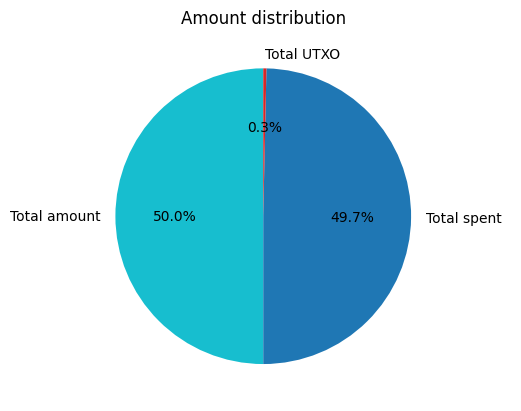

In [5]:
# --- (3) Total UTXO ---

# Calculation ...
spent_outputs = inputs.merge(outputs, left_on = ['prevTxId','prevTxPos'], right_on = ['txId','position']) # Merge inputs and outputs

total_amount = outputs.amount.sum() # Total amount is the sum of all outputs
total_spent = spent_outputs.amount.sum() # Total spent is the sum of all spent outputs
total_utxo = total_amount - total_spent # Total UTXO is the difference between the sum of all outputs and the sum of all spent outputs

print('Total UTXO:', total_utxo)

# Plotting ...
plt.title('Amount distribution')
plt.axis('equal')
plt.pie([total_amount, total_spent, total_utxo], autopct = '%1.1f%%', labels = ['Total amount', 'Total spent', 'Total UTXO'], colors = ['tab:cyan', 'tab:blue', 'tab:red'], startangle = 90)
plt.show()

### 4) Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un output e quella che lo consuma, per gli output spesi nel periodo considerato.

Come prima cosa creo due Dataframe separati dove in uno passo la merge tra inputs e transactions sul campo 'prevTxId' (ottenendo così tutte le transazioni che sono state create a partire da un output) e nell'altro passo la merge tra inputs e transactions ma questa volta sul campo 'txId' per ottenere la data in cui in determinato output è diventato un input e quindi è stato speso. Faccio la merge di questi due Dataframe per ottenere entrambe le colonne che chiamerò 'Creation date' e 'Spent date'. Tra queste due colonne faccio la differenza ed ottengo l'intervallo di tempo che intercorre tra la creazione di un output e il consumo di esso. È possibile che ci siano delle transazioni con campo 'Days between', precedentemente calcolato, negativo quindi aggiorno transactions e time_between in modo da avere solo transazioni con campo 'Days between' positivo. Questo è dovuto al fatto che i timestamp dei blocchi sono i timestamp dei miners, che non sono perfettamente sincronizzati e che un miner può anche modificare il timestamp, nel caso stia facendo qualche attacco (quindi non è un errore contenuto nel Dataset). Infine faccio una `groupby()` sulla differenza di giorni e ne calcolo la `size()` per poi fare un plot sul risultato.

Dal grafico si evince come la maggior parte degli output vengono spesi dopo pochi giorni dalla loro creazione.

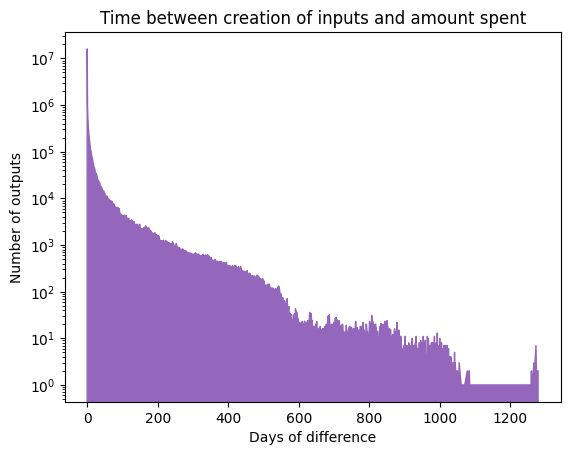

In [6]:
# --- (4) Time between creation of outputs and amount spent ---

# Calculation ...
created_tx = inputs.merge(transactions, left_on = 'prevTxId', right_on = 'txId').rename(columns = {'timestamp': 'Creation date'})[['prevTxId', 'prevTxPos', 'Creation date']] # Merge inputs and transactions to obtain the creation date of each input
spent_tx = inputs.merge(transactions, how = 'inner').rename(columns = {'timestamp': 'Spent date'})[['txId', 'prevTxId', 'prevTxPos', 'Spent date']] # Merge inputs and transactions to obtain the spent date of each input

time_between = spent_tx.merge(created_tx, how = 'inner', on = ['prevTxId', 'prevTxPos']) # Merge spent and created transactions
time_between['Days between'] = (time_between['Spent date'] - time_between['Creation date']).dt.days # Calculate difference between spent and created dates

# Some difference are negative, so remove them and update dataframes
negative_differences = time_between.loc[time_between['Days between'] < 0]
only_positive_dates_mask1 = ~transactions['txId'].isin(negative_differences['txId'])
transactions = transactions.loc[only_positive_dates_mask1]
time_between = time_between.loc[time_between['Days between'] >= 0]

# Group by days of difference
grouped_by_difference = time_between.groupby('Days between')['prevTxId'].size() # Group by days of difference and count the number of outputs
time_distribution = pd.DataFrame({'outputs': grouped_by_difference.values, 'days': grouped_by_difference.index}) # Create a dataframe with the number of outputs and the days of difference to plot a chart

# Plotting ...
plt.title('Time between creation of inputs and amount spent')
plt.xlabel('Days of difference')
plt.ylabel('Number of outputs')
plt.stackplot(time_distribution['days'], time_distribution['outputs'], color = 'tab:purple')
plt.yscale(value = 'log')
plt.show()

### 5.1) Distribuzione delle Fee per ogni transazione

Calcolo le fee positive e nulle per ogni transazione e faccio il plot del grafico risultante tramite un grafico a torta per mostrare la porzione di fee positive e nulle. Avendo testato il codice sia sul Dataset completo che su una versione ridotta (all'incirca dimezzata) ho notato come il numero di transazioni con fee nulle sia molto basso rispetto a quelle con fee positive sul Dataset completo, ma il numero di quelle positive diminuisca al diminuire della dimensione del Dataset. La porzione quindi diventa quasi uguale per entrambi i tipi di fee.

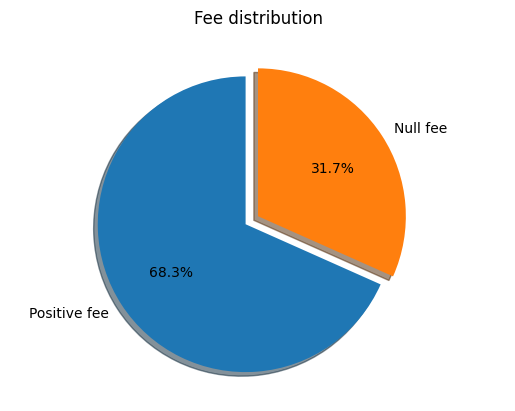

In [7]:
# --- (5) Personal analysis (Fee Distribution) ---

# Calculation ...
positive_fee_distribution = transactions.loc[transactions['fee'] > 0]
null_fee_distribution = transactions.loc[transactions['fee'] == 0]

# Plotting ...
explode = (0.1, 0)

plt.title('Fee distribution')
plt.axis('equal')
plt.pie([len(positive_fee_distribution), len(null_fee_distribution)], autopct = '%1.1f%%', explode = explode, labels = ['Positive fee', 'Null fee'], shadow = True, startangle = 90)
plt.show()

### 5.2) Distribuzione delle Fee positive e negative per ogni transazione, raggruppate per anno

Come al punto precente, ricavo da tutte le transazioni, quelle con fee positive e quelle con fee nulle. Raggruppo per anno e calcolo la **size()** per ogni anno. Faccio un plot di entrambi i risultati in modo da poterli confrontare tramite uno *stackplot* che permette di osservare l'andamento nel corso degli anni delle fee. Si può notare come il numero di transazioni sia con fee nulle che positive cresce molto rapidamente nel corso degli anni, specialmente a partire dal 2011.

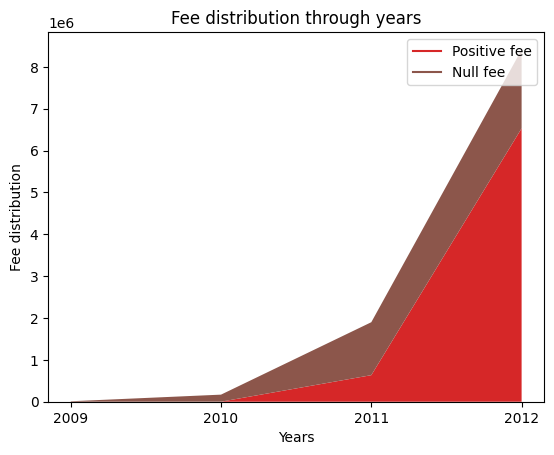

In [8]:
# --- (5) Personal analysis (Fee Distribution through years) ---

# Calculation ...
grouped_by_positive_fee = positive_fee_distribution.groupby(positive_fee_distribution['timestamp'].dt.year).size() # Group transactions with positive fees by year
grouped_by_null_fee = null_fee_distribution.groupby(null_fee_distribution['timestamp'].dt.year).size() # Group transactions with null fees by year

# Plotting ...
plt.title('Fee distribution through years')
plt.xlabel('Years')
plt.ylabel('Fee distribution')
plt.xticks([2009, 2010, 2011, 2012])
plt.plot([], [], color = 'tab:red')
plt.plot([], [], color = 'tab:brown')
plt.stackplot([2009, 2010, 2011, 2012], grouped_by_positive_fee, grouped_by_null_fee, colors = ['tab:red', 'tab:brown'])
plt.legend(['Positive fee', 'Null fee'])
plt.show()

### 5.3) Correlazione tra il costo di un output e la fee pagata e Heatmap della correlazione tra alcuni campi del Dataset

Faccio una semplice merge tra outputs e transactions e prelevo solo le colonne 'amount' e 'fee' per poi calcolare la correlazione tra di esse. Faccio poi uno scatter plot per mostrare tale correlazione. Ancora sotto si trova una heatmap che mostra la correlazione di alcuni campi del Dataset (calcolata tramite la correlazione di Pearson fornita anche da Pandas `corr()`). Inizialmente avevo fatto tale heatmap su tutti i dati ma in seguito ho rimosso i dati che a parer mio non influissero sulla correlazione generale. Si può notare come la correlazione tra 'amount' e 'fee' sia molto bassa, quindi il costo di un output non influenza la fee pagata. In una heatmap i valori si trovano in un intervallo compreso tra -1 e 1 quindi dati che hanno un coefficiente di correlazione vicino a 1 si dicono molto correlati (all'aumentare di uno, aumenta anche l'altro), mentre quando il coefficiente è vicino a -1 indica l'inverso (all'aumentare di uno, l'altro diminuisce). Di conseguenza ho semplicemente rimosso i dati che avevano un coefficiente di correlazione molto vicino allo 0 e che quindi non erano correlati.

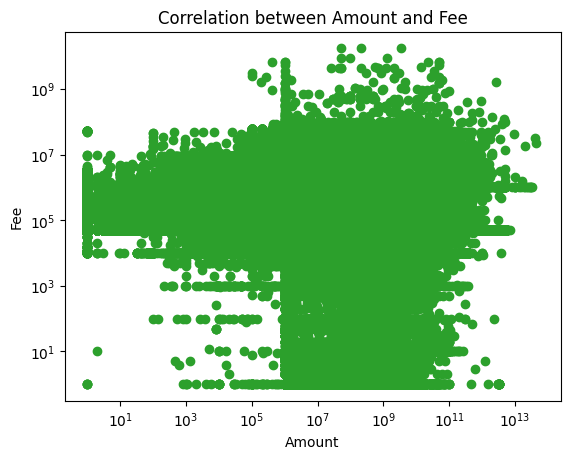

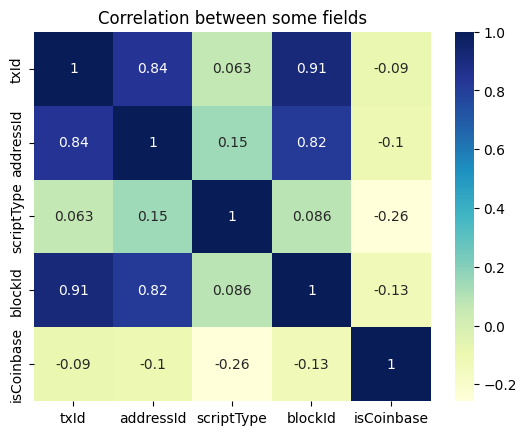

In [9]:
# --- (5) Personal analysis (Correlation between Amount and Fee) ---

# Calculation ...
outputs_tx = outputs.merge(transactions, on = 'txId') # Merge outputs and transactions to obtain the fee and the amount of each output

# Plotting ...

# Scatter plot to represent the correlation between Amount and Fee
plt.title('Correlation between Amount and Fee')
plt.xlabel('Amount')
plt.ylabel('Fee')
plt.scatter(outputs_tx['amount'], outputs_tx['fee'], color = 'tab:green')
plt.xscale(value = 'log')
plt.yscale(value = 'log')
plt.show()

# Heatmap to represent the correlation between some fields of the Dataset
seaborn_heatmap = sns.heatmap(outputs_tx[['txId', 'addressId', 'scriptType', 'blockId', 'isCoinbase']].corr(), annot = True, cmap = 'YlGnBu')
seaborn_heatmap.set_title('Correlation between some fields')
plt.show()

## Clustering

Prima di procedere con l'implementazione dell'algoritmo di address clustering ho bisogno di eseguire due merge. Il primo è tra inputs e transactions sul campo 'txId' in modo da ottenere tutte le transazioni e gli input con stesso ID. Eseguo poi una `groupby()` sul campo "txId" e conto il relativo numero di input ad esso associato. A questo punto seleziono dal Dataframe solamente le transazioni con un numero di input maggiore stretto di 1 in quanto quelle con numero di input uguale a 1 o a 0 (Coinbase) non infieriscono nel calcolo dei cluster e alla deanonimizzazione. Successivamente eseguo il merge del Dataframe ottenuto precedentemente con ouputs (considerando le posizioni) per ottenere il campo 'addressId' di ogni input. Infine uso la `groupby()` su 'txId' e del campo 'addressId' e applico l'oggetto `list()` a tutti gli address relativi ad un determinato ID. L'algoritmo di clustering procede tramite la seguente logica:

1) Aggiungi tutti i possibili nodi (indirizzi) al grafo
2) Per ogni lista di indirizzi contenuta in `transactions_addresses.values()`
    - Prendi il primo elemento della lista e collegalo con tutti gli altri elementi della lista tramite la funzione `add_edge(x, y)` che permette di aggiungere un arco tra il nodo x e il nodo y (ogni indirizzo è un nodo e ogni arco tra un nodo ed un altro è un cammino che li collega). Ovviamente per questioni di efficienza bisogna anche controllare che l'arco che vogliamo aggiungere non sia già presente nel grafo e che non stiamo collegando un nodo con se stesso (*self loop*). 
3) Calcola le componenti debolmente connesse del grafo

Una volta costruito il grafo, e dopo aver calcolato le componenti debolmente connesse di esso tramite il metodo `nx.weakly_connected_components()` (fornito dalla libreria networkX), è possibile ottenere un oggetto *generator* che rappresenta le componenti debolmente connesse (quindi i *cluster*) del grafo. Creo una copia ordinata delle componenti e una lista conentente la dimensione di ogni cluster per poi ottenere i 10 cluster di dimensione maggiore. Ho inoltre implementato una funzione di *hash* che a partire da un indirizzo restituisce il medesimo hashato correttamente attraverso il file di mapping fornito. Quindi dopo aver ottenuto i 10 cluster più grandi semplicemente applico una `map()` ad ogni indirizzo contenuto in ogni cluster per ottenere il suo corrispettivo hashato. In questo modo è possibile ottenere i 10 cluster più grandi con i loro indirizzi hashati e passare alla fase di Web Scraping senza dover hashare ogni indirizzo prima di provare a deanonimizzare, risparmiando così tempo e risorse.

Di seguito calcolo qualche valore per compiere della statistica descrittiva sui cluster ottenuti, come il valore massimo, minimo e medio della dimensione dei cluster, per poi fare un plot sulla distribuzione della dimensione dei cluster. È possibile notare come i cluster abbiano una dimensione abbastanza simile e inoltre il numero di cluster è di circa 5 milioni dato che al suo interno sono presenti molti cluster da un solo indirizzo. Questo accade perchè al primo punto dell'algoritmo di clustering ho aggiunto al grafo tutti i possibili nodi (indirizzi) tramite la funzione `add_nodes_from()` nonostante quelli con dimensione 1 non influiranno sui calcoli successivi. Successivamente bisogna creare tutti gli archi possibili tra gli indirizzi senza creare self loop o aggiungere archi esistenti e calcolare le componenti debolmente connesse.

Top 10 clusters size: [259699, 120078, 99348, 76290, 30807, 26651, 26363, 20047, 19359, 16851]
Number of clusters: 4821931
Max cluster size: 259699
Min cluster size: 1
Mean clustering size: 1.806085777668739


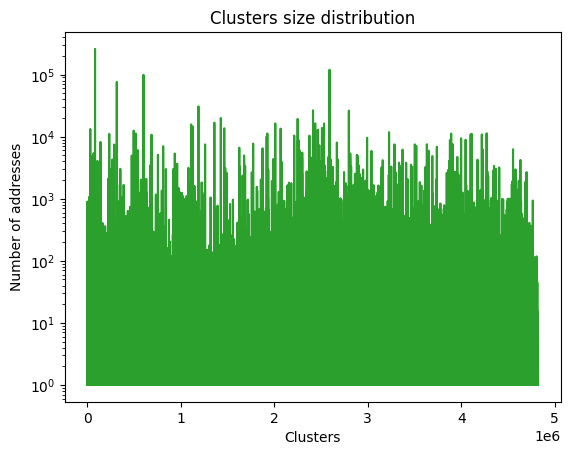

In [11]:
transactions_graph = nx.DiGraph() # Create a directed graph

# Hash specific address
def hash(address):
  return mapping.loc[address]['hash'] # Get the hash of the address

inputs_tx = inputs.merge(transactions, how = 'inner')[['txId', 'prevTxId', 'prevTxPos']] # Merge inputs and transactions
grouped_by_inputs = inputs_tx.groupby('txId')['prevTxId'].size() # Group by txId and count the number of inputs

mask = list(map(lambda inp: (inp > 1), grouped_by_inputs.values)) # Map each value of grouped_by_inputs with a boolean value (True if the value is greater than 1, False otherwise)

more_than_one_tx = (inputs_tx.loc[inputs_tx['txId'].isin((grouped_by_inputs.loc[mask]).index)]).reset_index(drop = True) # Get the inputs with more than one txId

all_tx = more_than_one_tx.merge(outputs, left_on = ['prevTxId', 'prevTxPos'], right_on = ['txId', 'position']).rename(columns = {'txId_x': 'txId'})[['txId', 'addressId']] # Merge the previous dataframe with outputs to obtain the addressId of each input

transactions_addresses = all_tx.groupby('txId')['addressId'].apply(list).to_dict() # Create a dictionary with txId as key and a list of addresses as value

# --- Clustering Algorithm ---

# Step 1
transactions_graph.add_nodes_from(mapping.index) # Add all nodes (addresses) to the graph

# Step 2
# For each address list in transactions_addresses
for addresses in transactions_addresses.values():
  head = addresses[0] # Get the first address of the list
  # For each address in the list
  for address in addresses[1:]:
    # If the address is not the head and the edge hasn't been added yet to the graph (to avoid duplicates or self-loops)
    if not(transactions_graph.has_edge(head, address)) and (address != head):
      transactions_graph.add_edge(head, address) # Add the edge to the graph

# Step 3
generator = nx.weakly_connected_components(transactions_graph) # Get the connected components of the graph

clusters = list(generator) # Get the connected components
clusters_len = list(map(lambda c : len(c), clusters)) # Map each components with its length (cluster)

sorted_clusters = sorted(clusters, key = len, reverse = True) # Get a copy of the connected components sorted by length (disceding order)
sorted_clusters_len = sorted(clusters_len, reverse = True) # Map each components with its length (cluster) ordered by length (descending order)

top10_clusters = sorted_clusters[:10] # Get the top 10 clusters
hashed_top10_clusters = list(map(lambda cluster : list(map(lambda address : hash(address), cluster)), top10_clusters)) # Map each address of each cluster with its hash
top10_clusters_len = sorted_clusters_len[:10] # Get the top 10 clusters length
print('Top 10 clusters size:', top10_clusters_len)
print('Number of clusters:', len(clusters))

max_cluster = top10_clusters_len[0] # Get the max cluster
print('Max cluster size:', max_cluster)
min_cluster = sorted_clusters_len[-1:][0] # Get the min cluster
print('Min cluster size:', min_cluster)
mean_clustering = np.mean(sorted_clusters_len) # Get the mean clustering
print('Mean clustering size:', mean_clustering)

# Plotting ...
plt.title('Clusters size distribution')
plt.xlabel('Clusters')
plt.ylabel('Number of addresses')
plt.plot(clusters_len, color = 'tab:green')
plt.yscale(value = 'log')
plt.show()

## Web Scraping

In questa sezione l'obiettivo principale è quello di cercare di deanonimizzare più indirizzi possibili in modo tale da riuscire ad associare ad ogni cluster un determinato Wallet (o Servizio) a cui appartiene. Ciò è reso possibile grazie ai 10 cluster di dimensione maggiore ottenuti al punto precedente mediante l'algoritmo di address clustering, ma non basta per risolvere il problema. Ho bisogno di utilizzare due siti che si occupano di deanonimizzare degli indirizzi restituendo il loro wallet address (se lo trovano). Ovviamente non dovrò andare direttamente sul sito ed eseguire manualmente le ricerche, ma dopo un'attenta analisi di entrambi i siti sono riuscito ad ottenere le informazioni necessarie per fare Web Scraping ed automatizzare il procedimento tramite codice. I due siti sono:

- [Wallet Explorer](https://www.walletexplorer.com/): è un sito che permette di cercare un indirizzo e restituisce il wallet address a cui è associato. Inoltre restituisce anche il numero di transazioni effettuate da quell'indirizzo e il numero di indirizzi collegati a quel wallet address. Una volta arrivato sulla home page noto una schermata abbastanza semplice con una barra di ricerca al centro dello schermo ed un tasto "Search" per effettuare le ricerche. Dopo una serie di ricerche per capire come la pagina rispondesse sono arrivato alla conclusione che bastasse fare un `get()` della pagina di mio interesse relativa all'address che voglio cercare, aggiungendo all'url la query con parametro `q = address` dove "address" è l'indirizzo *i-esimo* contenuto nel cluster *j*. Tramite la libreria **BeautifulSoup** è possibile estrarre il codice html della pagina e cercare il tag che contiene il wallet address (in questo caso, una volta che ci troviamo nella pagina relativa al wallett dell'address, è il primo tag *h2*). Se il tag è presente allora estraggo il nome del wallet (tramite una funzione impletata personalmente), e se non inizia con "[" significa che il sito è riuscito a deanonimizzare l'indirizzo e quindi posso associare al cluster *j* il wallet con il nome trovato. Memorizzo quindi in un dizionario la coppia (cluster: wallet) e mi fermo. Se tra tutti gli indirizzi non riesce a deanonimizzarne neanche uno allora il cluser viene associato ad un wallet "Unknown". Dopo molti tentativi sono arrivati alla conclusione che è abbastanza complesso deanonimizzare un cluster di dimensioni elevate in quanto se l'algoritmo non riuscisse a trovare subito il wallet name dovrebbe continuare ed al caso pessimo la ricerca costerebbe **O(n)** con *n* numero di indirizzi contenuti in un cluster (per ogni cluster) dal punto di vista computazionale, il problema è anche la questione del tempo effettivo che la macchina impiegherebbe per fare la ricerca e questo può dipendere anche da fattori esterni come la connessione e la velocità del sito nel caricare le pagine HTML. Quindi cercare finchè non si arriva all'ultimo elemento del cluster rappresenterebbe una ricerca molto costosa e si andrebbe in contro ad un ulteriore problema che ho personalmente incontrato: se il sito nota un numero eccessivo di richieste effettuate, restituisce uno *status code* uguale 429 che indica un errore "Too many requests" che gestisco in quanto una volta ricevuto tale errore esco dal loop creato e dico che non ho trovato alcun wallet stampando in console il problema. Per ovviare a questo problema ho inserito, tra una richiesta e l'altra, un intervallo di tempo di 5 secondi in modo tale da agire quasi con i tempi di un umano. Ho inoltre aggiunto un controllo sul numero massimo di tentativi che l'algoritmo può compiere se continua a non trovare un wallet per quel cluster e ho settato questo limite a 15. Purtroppo facendo così si alza di un po' il tempo di esecuzione ma almeno ho la certezza di deanonimizzare più cluster possibili arrivando fino all'ultimo cluster.

- [Bitcon Info Charts](https://bitinfocharts.com/): il ragionamento che c'è e le funzionalità sono molto simili a quelle di Wallet Explorer, ma in questo caso la pagina di ricerca è un po' più complessa. Dopo aver fatto un'analisi della pagina ho notato che potevo costruire la query della `get()` scrivendo semplicemente *bitcoin/address* (dove address è l'indirizzo che voglio deanonimizzare) dopo la url della pagina iniziale. Per il resto il funzionamento dell'algoritmo di deanonimizzazione funziona in modo praticamente identico a quello di Wallet Explorer, con la differenza che utilizzo **Selenium** per automatizzare il processo di ricerca e per estrarre il nome del wallet. Con Selenium la differenza sta nel fatto che agiamo in maniera più simile ad un umano e quindi abbiamo più probabilità di non essere riconosciuti come un bot. Per funzionare correttamente ho quindi bisogno di utilizzare un *WebDriver*, che permette al codice di comunicare con il driver del Browser (esiste un driver diverso per ogni Browser). Dato che a volte le pagine Html impiegano del tempo per eseguire il codice JavaScript o comunque per caricare i contenuto, è possibile che se proviamo ad estrarre qualche informazione tramite scraping non otteniamo nulla. Per questo motivo i WebDriver implementano due meccanismi di sincronizzazione (implicita ed esplicita):

  - Sincronizzazione implicita: il driver ripete la ricerca a intervalli di tempo regolari (eseguendo *polling*) per un certo periodo di tempo. Una volta settata rimane valida finchè l'oggetto WebDriver su cui è invocata rimane attivo. `driver.implicitly_wait(time)`
  - Sincronizzazione esplicita: il thread in esecuzione viene interrotto finchè non si verifica una condizione. L'esecuzione riprende se la condizione è vera o se il timeout è scaduto. `WebDriverWait(driver, time).until(condition)`

  In questo caso ho bisogno di utilizzare la sincronizzazione esplicita per aspettare che il nome del wallet sia completamente caricato prima di estrarlo. Per fare ciò utilizzo la funzione `presence_of_element_located()` (passandogli il relativo XPath del tag che cerco) che restituisce l'elemento se è presente o meno nella pagina. Una volta che l'elemento è presente nella pagina posso estrarre il nome del wallet e associarlo al cluster *j*. Osservando l'esecuzione del codice ho notato che a volte il nome del wallet non viene mai caricato (anche aspettando tanto tempo) quindi ho fatto in modo che se dopo 10 secondi non trova il nome vuol dire che la pagina non è riuscita a caricarlo e quindi semplicemente salta l'iterazione corrente e passa al prossimo indirizzo.

  Da questo sito i "problemi" riscontrati sono diversi in quanto ho notato da subito che sia molto più veloce di Wallet Explorer nel deanonimizzare gli indirizzi ma dopo essere riuscito a deanonimizzare quattro cluster ho ricevuto un "blocco" da parte del sito che non mi permetteva più di fare richieste. Il sito utilizza un CAPTCHA Cloudflare per evitare che vengano fatte troppe richieste al sito e riesce quindi a riconoscere che chi sta facendo le richieste sia un bot o meno. Nel mio caso ho dovuto aspettare molto prima di poter testare nuovamente il codice (e ho bypassato il CAPTCHA con una VPN) quindi per le successive volte ho aggiunto un intervallo di tempo di 5 secondi tra una richiesta e l'altra.

In entrambi i casi ad ogni esecuzione salvo i risultati ottenuti all'interno di un file JSON (un file diverso per entrambi i metodi). L'utilità di provare a deanonimizzare gli indirizzi tramite due siti diversi è che è molto probabile che uno dei due non riesca a deanonimizzare un determinato indirizzo, ma l'altro si. In questo modo ho più probabilità di deanonimizzare più indirizzi possibili (quindi cluster).

### Wallet Explorer

In [ ]:
# --- Wallet Explorer ---
wallet_explorer_url = 'https://www.walletexplorer.com/'

wallets_WE = {} # Dictionary to store the couple (cluster, wallet name)
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 ' + ' (KHTML, like Gecko) Chrome/61.0.3163.100Safari/537.36'}

# Extract the wallet name from the raw text (implemented if exists a spaced wallet name)
def extract_wallet_name(wallet_string):
  wallet_name = ''

  # For each character in the string (starting from the 7th character)
  for i in range(7, len(wallet_string), 1):
    if wallet_string[i] == '(': # If the character is '(' break the loop
      break
    wallet_name += wallet_string[i] # Add the character to the wallet name

  return wallet_name[:-1]

# Try to deanonymize addresses and get the wallet name
def deanonymize_addresses_WE(url, cluster, c_index, wallets):
  current_cluster = 'Cluster ' + str(c_index) # Get the current cluster
  wallet_name_found = False # Boolean to check if the wallet name has been found
  wallet_name = '' # Initialize the wallet name
  max_tries = 0 # Max number of tries to get the wallet name (starting from 0 and limited to 15)

  # For each hashed address
  for address in cluster:
    # If the max number of tries has been reached
    if max_tries == 15:
      break # Break the loop

    r = requests.get(url, {'q': address}, headers = headers) # Try to reach the page

    # If the status code is 429 (Too many requests)
    if r.status_code == 429:
      print('Too many requests, try again later')
      break

    html = r.text # Get the html page

    soup = BeautifulSoup(html, 'html.parser') # Parse the html using BeautifulSoup

    # Get the wallet name
    wallet_title = soup.find('h2') # Find the first h2 tag (it contains the wallet name)

    # If the wallet tag is not None
    if wallet_title is not None:
      wallet_name = extract_wallet_name(wallet_title.text) # Get the wallet name
      # Check if the wallet name is not inside "[]" (deanonymized correctly)
      if not wallet_name.startswith('['): 
        wallets[current_cluster] = wallet_name # Add the couple (cluster, wallet name) to the wallets dictionary
        wallet_name_found = True # Set the boolean to True
        break # Break the loop (every address of the cluster has the same wallet name)

    max_tries += 1 # Increment the max number of tries
    time.sleep(5) # Wait 5 seconds before the next request

  if not wallet_name_found:
    wallet_name = 'Unknown wallet name'
    wallets[current_cluster] = wallet_name # The wallet name is unknown
  
  # Append the couple (cluster, wallet name) to the json file
  data = json.loads(json.dumps(wallets)) # Load the current object
  data.update({current_cluster: wallet_name}) # Add the couple (cluster, wallet name)

  # Overwrite the json file with the updated object
  with open('wallets_WE.json', 'w') as f:
    f.write(json.dumps(data, indent = 2))
  
for index in range(len(hashed_top10_clusters)):
  deanonymize_addresses_WE(wallet_explorer_url, hashed_top10_clusters[index], index + 1, wallets_WE)

### Bitcoin Info Charts

In [ ]:
# --- BitInfoCharts ---
bitcoin_info_charts_url = 'https://bitinfocharts.com/'

driver = webdriver.Chrome() # Create a new Chrome web driver to cominicate with the browser

wallets_BIC = {} # Dictionary to store the couple (cluster, wallet name)

def deanonymize_addresses_BIC(url, cluster, c_index, wallets):
  current_cluster = 'Cluster ' + str(c_index) # Get the current cluster
  wallet_name_found = False # Boolean to check if the wallet name has been found
  wallet_name = '' # Initialize the wallet name
  max_tries = 0 # Max number of tries to get the wallet name (starting from 0 and limited to 15)

  # For each hashed address
  for address in cluster:
    # If the max number of tries has been reached
    if max_tries == 15:
      break # Break the loop

    driver.get(url + 'bitcoin/address/' + address) # Get the url of the address

    try:
      # Wait until the wallet name is loaded and get it via XPath
      wallet_name = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[3]/div[3]/table/tbody/tr/td/table/tbody/tr[1]/td[2]/small/a'))).text.split(': ')[1] # Get the wallet name

      # If the wallet tag is not None
      if wallet_name is not None:
        # Check if the wallet name is not a number (deanonymized correctly)
        if not wallet_name.isdigit(): 
          wallets[current_cluster] = wallet_name # Add the couple (cluster, wallet name) to the wallets dictionary
          wallet_name_found = True # Set the boolean to True
          break # Break the loop (every address of the cluster has the same wallet name)
    except:
      print(f'TimeoutException, the wallet name has not been loaded to the html for the address {address}')
    
    max_tries += 1 # Increment the max number of tries
    time.sleep(5) # Wait 5 seconds before the next request

  if not wallet_name_found:
    wallet_name = 'Unknown wallet name'
    wallets[current_cluster] = wallet_name # The wallet name is unknown

  # Append the couple (cluster, wallet name) to the json file
  data = json.loads(json.dumps(wallets)) # Load the current object
  data.update({current_cluster: wallet_name}) # Add the couple (cluster, wallet name)

  # Overwrite the json file with the updated object
  with open('wallets_BIC.json', 'w') as f:
    f.write(json.dumps(data, indent = 2))

for index in range(len(hashed_top10_clusters)):
  deanonymize_addresses_BIC(bitcoin_info_charts_url, hashed_top10_clusters[index], index + 1, wallets_BIC)

## Conclusioni

Per quanto riguarda la parte di Web Scraping dopo un'attenta analisi e svariate esecuzioni del codice sono arrivato alle seguenti conclusioni:

- Il tempo impiegato per deanonimizzare gli indirizzi è abbastanza elevato (circa 6-7 minuti) per entrambi i metodi. Questo potrebbe essere ridotto semplicemente riducendo l'intervallo di tempo tra una richiesta e l'altra (ma sarebbe difficile trovare un tempo che ci permetta di mandare tutte le richieste senza ottenere l'errore delle troppe richieste), oppure riducendo il numero massimo di tentativi che l'algoritmo di ricerca possa fare prima di dire che non è riuscito a trovare un wallet name. Quest'ultima soluzione però potrebbe portare ad un numero di cluster deanonimizzati minore.
- Usare due siti diversi per la deanonimizzazione permette di deanonimizzare più indirizzi diversi ma fa sorgere anche inconsistenze in quanto dai risultati da me ottenuti alcuni cluster non vengono associati allo stesso wallet da entrambi i metodi. Una strategia utile sarebbe provare a deanonimizzare i cluster che un metodo non è riuscito a deanonimizzare con l'altro metodo. Nei risultati in fondo al notebook i wallet evidenziati in grassetto sono i wallet che sono stati deanonimizzati da entrambi i metodi in maniera identica.

La ragione per cui Wallet Explorer e Bitcoin Info Charts de-anonimizzano in modo diverso potrebbe essere dovuta a diversi algoritmi di analisi e metodi di acquisizione dati utilizzati dai due siti. Poiché le informazioni sulle transazioni Bitcoin sono pubbliche e registrate sulla blockchain, è possibile analizzare e collegare gli indirizzi Bitcoin alle transazioni e, in alcuni casi, ai wallet associati. 

Tuttavia, il processo di de-anonimizzazione richiede analisi e correlazioni tra indirizzi e transazioni, che possono essere complesse e soggette a errori (ad esempio Wallet Explorer, a causa di CoinJoin, associa erroneamente svariate transazioni allo stesso wallet). Inoltre, le informazioni disponibili su entrambi i siti potrebbero non essere complete o aggiornate in tempo reale, il che potrebbe influire sulle differenze nei risultati di de-anonimizzazione.

Cercando un po' su Internet ho trovato alcune informazioni riguardo i due siti:

Riguardo Wallet Explorer, usa la seguente logica per associare gli indirizzi ai wallet: "se due indirizzi appaiono come input nella stessa transazione, si assume che appartengano allo stessa wallet". Questo perché di solito è necessario avere entrambe le chiavi private per firmare la transazione. I suoi wallet sono cluster di indirizzi tali che tutti gli indirizzi in un insieme sono collegati da un percorso di uno o più di questi collegamenti, e non c'è connessione tra due indirizzi in cluster diversi. L'algoritmo può fallire in due modi:

- Se BitPay (per esempio) ha alcuni indirizzi di ricezione che non sono mai stati uniti agli altri, quegli indirizzi appariranno come una wallet separato con un "nome" numerico generico.

- L'altro possibile fallimento è che si possa emettere una transazione in cui gli input appartengono a due persone diverse, ognuna delle quali firma la propria parte della transazione. Questo accade, come anticipato, a causa del servizio CoinJoin.

Sempre riguardo Wallet Explorer, ho trovato molti pareri comuni riguardo la sua inefficienza e la sua imprecisione nel restituire i risultati di de-anonimizzazione. Questo è dovuto al fatto che il sito non è aggiornato da molto tempo e quindi non è in grado di de-anonimizzare gli indirizzi più recenti (ecco spiegato il caso in cui restituisce un numero invece di un wallet).

Non sono riuscito a trovare ulteriori informazioni su Bitcoin Info Charts quindi suppongo usi un'euristica differenta da Wallet Explorer o abbiano dati diversi su cui basarsi.

*fonte: [https://www.reddit.com/r/Bitcoin/](https://www.reddit.com/r/Bitcoin/)*

### Risultati ottenuti

Wallet Explorer:

- Cluster 1: CoinJoinMess
- Cluster 2: **SilkRoadMarketplace**
- Cluster 3: Unknown wallet name
- Cluster 4: **Instawallet.org**
- Cluster 5: BTC-e.com-old
- Cluster 6: Unknown wallet name
- Cluster 7: BtcDice.com
- Cluster 8: Unknown wallet name
- Cluster 9: Unknown wallet name
- Cluster 10: **Bitcoin.de-old**

Bitcoin Info Charts:

- Cluster 1: F2Pool
- Cluster 2: **SilkRoadMarketplace**
- Cluster 3: Unknown wallet name
- Cluster 4: **Instawallet.org**
- Cluster 5: Eligius
- Cluster 6: Unknown wallet name
- Cluster 7: Unknown wallet name
- Cluster 8: Unknown wallet name
- Cluster 9: Unknown wallet name
- Cluster 10: **Bitcoin.de-old**


### Alcune informazioni sui wallet deanonimizzati

**CoinJoin** è un metodo di privacy utilizzato nelle transazioni di criptovalute, come Bitcoin. Consiste nell'unire più transazioni in un'unica transazione combinata, rendendo più difficile l'individuazione delle relazioni tra i diversi indirizzi di mittente e destinatario. Ad esempio, se Alice, Bob e Charlie desiderano inviare Bitcoin a destinatari diversi, possono utilizzare CoinJoin per unire le loro transazioni in una singola transazione che comprende i pagamenti di tutti e tre. In questo modo, risulta complicato per gli osservatori esterni stabilire chi ha inviato Bitcoin a quale destinatario, poiché le transazioni sono state mescolate tra loro. È importante notare che CoinJoin non è una funzionalità integrata nel protocollo Bitcoin stesso, ma piuttosto una tecnica implementata da servizi e software di terze parti.

**F2Pool** è una delle più grandi e popolari pool di mining di criptovalute al mondo. È stata una delle prime pool di mining a supportare il mining di Bitcoin e altre criptovalute. Come pool di mining, F2Pool offre un'infrastruttura condivisa in cui i minatori di criptovalute possono unire le loro risorse computazionali per aumentare le possibilità di successo nel mining di blocchi. Il mining di criptovalute coinvolge la risoluzione di complessi problemi matematici per confermare le transazioni e garantire la sicurezza della rete. I minatori che riescono a risolvere questi problemi vengono ricompensati con nuove monete emesse e commissioni di transazione. Una delle caratteristiche distintive di F2Pool è la sua dimensione e il suo hash power significativo. L'hash power si riferisce alla potenza di calcolo combinata dei minatori all'interno di una pool.

**SilkRoadMarketplace** era un sito di commercio elettronico che funzionava attraverso i servizi nascosti del software di anonimato *Tor*. Solo attraverso Tor, infatti, era possibile accedere al sito. Vari prodotti venduti su Silk Road sono classificati come prodotti di contrabbando dalla maggioranza delle giurisdizioni mondiali. Silk Road è stato definito come "Amazon delle droghe". Il 3 ottobre 2013 Silk Road fu chiuso dall'FBI. Ai primi di novembre ne fu annunciata la riapertura da parte dello pseudonimo Dread Pirate Roberts, nonostante l'FBI avesse arrestato la persona che secondo loro si celava dietro a quel nome. Il 6 novembre 2014 Silk Road fu chiuso definitivamente dall'FBI.

**Instawallet**, in passato, era un eWallet che richiedeva l'accesso e la spesa dei fondi nel portafoglio solo tramite l'indirizzo del sito web (URL). Ciò consentiva l'utilizzo del servizio in modo anonimo, senza necessitare nemmeno di un indirizzo email. Il sito includeva un avviso che metteva in guardia sull'uso: "Instawallet non aspira ad essere una banca di Bitcoin e, pertanto, può fornire solo un livello medio di sicurezza. Si prega di non conservare qui più di qualche spicciolo".

**BTC-e** era una piattaforma di trading di criptovalute che mirava principalmente al pubblico russo, con server situati negli Stati Uniti, fino a quando il governo degli Stati Uniti ha sequestrato il loro sito web e tutti i fondi nel 2017. Fino al 2015 gestiva circa il 3% di tutto il volume di scambio di Bitcoin.

**Eligius** è una pool di mining. A partire dal 23 ottobre 2012, Eligius è gestito da *wizkid057*. Per utilizzarlo, un minatore deve semplicemente essere indirizzato a *stratum.mining.eligius.st* sulla porta 3334, con il nome utente impostato su un indirizzo bitcoin valido (che riceve il pagamento). Non è necessaria alcuna registrazione e i concetti di base sono:

- La pool non applica commissioni (fee)
- Quando viene trovato un blocco, tutti i minatori che hanno raggiunto la soglia di pagamento minima vengono pagati tramite la transazione di generazione
- La pool quasi mai ha i fondi dei minatori, poiché vengono pagati direttamente ai minatori dalla ricompensa del blocco
- Se un blocco diventa "orfano", le sue quote diventano parte della distribuzione della ricompensa del blocco successivo.
- Nessuna registrazione, gli indirizzi bitcoin vengono utilizzati come nomi utente

**BtcDice** era un sito web dedicato al gioco d'azzardo basato su Bitcoin. Offriva un servizio di "dice game" (gioco dei dadi) online, in cui gli utenti potevano scommettere e vincere Bitcoin. Il funzionamento di BtcDice era abbastanza semplice: gli utenti potevano inserire una quantità di Bitcoin come scommessa e selezionare un valore numerico su cui scommettere. Successivamente, il sito generava casualmente un numero e se il numero generato fosse stato inferiore al valore selezionato dall'utente, questi avrebbe vinto la scommessa e ottenuto una quantità di Bitcoin in base alle regole del gioco.

**Bitcoin.de** è un marketplace in cui i Bitcoin vengono scambiati direttamente tra gli utenti e agisce come trustee per i Bitcoin offerti. sul sito. È anche possibile utilizzare l'account come portafoglio online per i Bitcoin. Attualmente, offre il servizio di scambio tra Bitcoin ed Euro. I metodi di pagamento supportati sono il bonifico bancario, SEPA e Moneybookers.

*fonte: [Bitcoin Wiki](https://en.bitcoin.it/wiki/Main_Page)*